#Aviation Risk Analysis
##1.Business Understanding
##Stakeholder

Head of the new Aviation Division

##Business Problem

The company plans to enter the aviation industry by purchasing and operating aircraft for commercial and private use. Aviation carries inherent safety and financial risks, and leadership needs data-driven guidance on which aircraft types present the lowest operational risk.

##Key Business Questions

Which aircraft categories have the lowest accident severity?

Which aircraft categories are involved in fewer accidents?

Which manufacturers demonstrate the strongest long-term safety record?

The objective is to minimize safety, insurance, and liability risk in early-stage investments.

##2. Data Understanding
###Data Source

National Transportation Safety Board (NTSB) Aviation Accident Dataset (1962–2023)

###Description

Each row represents an авиаtion accident or incident and includes:

Aircraft characteristics

Injury severity

Purpose of flight

Date of occurrence

This analysis focuses on risk indicators, not narrative investigation details.

##3. Data Preparation
Import Libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Load Dataset

In [30]:
df = pd.read_csv("Aviation_Data.csv", low_memory=False)
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


Inspection of the Dataset

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

###Column Selection

Only columns relevant to risk analysis are retained.

In [32]:
columns_of_interest = [
'Event.Date',
'Aircraft.Category',
'Make',
'Model',
'Purpose.of.flight',
'Injury.Severity',
'Total.Fatal.Injuries',
'Total.Serious.Injuries',
'Total.Minor.Injuries'
]


df = df[columns_of_interest]

###Handle misssing values

In [33]:
df = df.dropna(subset=['Aircraft.Category', 'Injury.Severity'])

Convert Date to Year

In [34]:
df['Event.Year'] = pd.to_datetime(df['Event.Date'], errors='coerce').dt.year

##Create Severity Score

To quantify risk, injury outcomes are mapped to a numeric severity score.

In [35]:
severity_map = {
'Fatal': 3,
'Serious': 2,
'Minor': 1,
'None': 0
}


df['Severity.Score'] = df['Injury.Severity'].map(severity_map)

Remove Records with Unknown Severity

In [36]:
df = df.dropna(subset=['Severity.Score'])

##4. Exploratory Data Analysis
4.1 Accident Frequency by Aircraft Category

In [37]:
category_counts = (
df.groupby('Aircraft.Category')
.size()
.sort_values(ascending=False)
)
category_counts

,0
Aircraft.Category,
Airplane,4530
Helicopter,743
Glider,83
Weight-Shift,54
Gyrocraft,39
Balloon,21
Powered Parachute,15
WSFT,8
Ultralight,7


Visualization

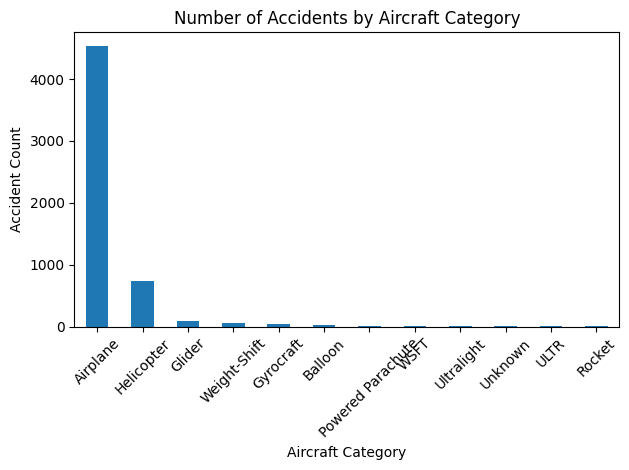

In [38]:
plt.figure()
category_counts.plot(kind='bar')
plt.title('Number of Accidents by Aircraft Category')
plt.xlabel('Aircraft Category')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4.2 Average Severity by Aircraft Category

In [39]:
category_severity = (
df.groupby('Aircraft.Category')['Severity.Score']
.mean()
.sort_values(ascending=False)
)
category_severity

,Severity.Score
Aircraft.Category,
Ultralight,3.000000
Unknown,3.000000
Weight-Shift,3.000000
Rocket,3.000000
Airplane,2.899117
Glider,2.879518
Helicopter,2.877524
Powered Parachute,2.866667
WSFT,2.750000


visualization

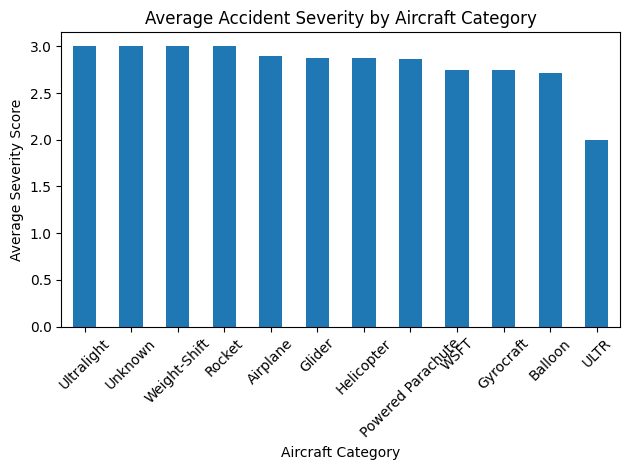

In [40]:
plt.figure()
category_severity.plot(kind='bar')
plt.title('Average Accident Severity by Aircraft Category')
plt.xlabel('Aircraft Category')
plt.ylabel('Average Severity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

####4.3 Lowest-Risk Aircraft Manufacturers

Only manufacturers with sufficient historical data are included.

In [41]:
make_counts = df['Make'].value_counts()
reliable_makes = make_counts[make_counts >= 100].index


filtered_df = df[df['Make'].isin(reliable_makes)]

make_severity = (
filtered_df.groupby('Make')['Severity.Score']
.mean()
.sort_values()
.head(10)
)
make_severity

,Severity.Score
Make,
CESSNA,2.860648
PIPER,2.902108
BELL,2.902299
ROBINSON,2.946667
BEECH,2.960000
Cessna,3.000000
Piper,3.000000


visualization

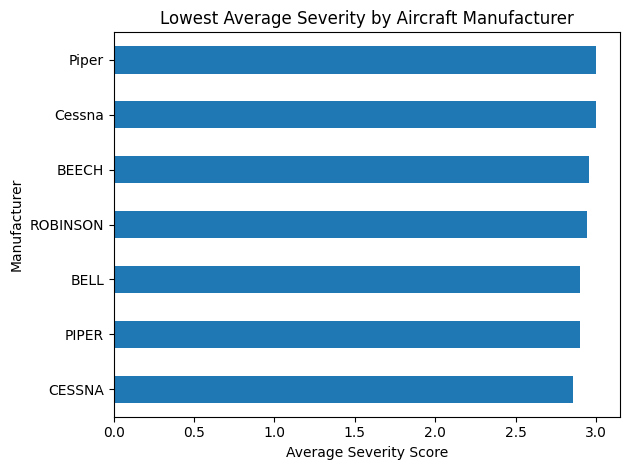

In [42]:
plt.figure()
make_severity.plot(kind='barh')
plt.title('Lowest Average Severity by Aircraft Manufacturer')
plt.xlabel('Average Severity Score')
plt.ylabel('Manufacturer')
plt.tight_layout()
plt.show()

#5. Conclusions and Business Recommendations
##Key Findings

Fixed-wing commercial aircraft show lower average severity compared to other categories.

Helicopters and experimental aircraft show higher severity outcomes.

Established manufacturers demonstrate stronger safety performance.

##Business Recommendations

Invest first in fixed-wing commercial aircraft to minimize safety and liability risk.

Avoid rotorcraft and experimental aircraft during initial expansion.

Procure aircraft from proven manufacturers with strong historical safety records.

##6.Thank You

This analysis provides a data-driven foundation for safer aviation investment decisions.